In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install scanpy

     |████████████████████████████████| 2.0 MB 8.9 MB/s 
     |████████████████████████████████| 86 kB 6.5 MB/s 
     |████████████████████████████████| 91 kB 10.4 MB/s 
     |████████████████████████████████| 1.1 MB 54.4 MB/s 
     |████████████████████████████████| 63 kB 2.1 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82709 sha256=ad4863d0af2233b51f9692ab6e2ec865c22868185edb5aac16e38f1ae1fe9cd6
  Stored in directory: /root/.cache/pip/wheels/84/1b/c6/aaf68a748122632967cef4dffef68224eb16798b6793257d82
  Created wheel for pynndescent: filename=pynndescent-0.5.5-py3-none-any.whl size=52603 sha256=7897b40997409f3d27beacf8137475276d5089864012f2858d3264158084e34e
  Stored in directory: /root/.cache/pip/wheels/af/e9/33/04db1436df0757c42fda8ea6796d7a8586e23c85fac355f476
  Created wheel for sinfo: filename=sinfo-0.3.4-py3-none-any.whl size=7899 sha256=54a022d3c3044bc128d80542bce1a358c4c0563f8d06652b496995033fc2e920
  Stored in directory: /root/.cache/p

In [3]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib as mpl
import anndata as ad
import seaborn as sns
from collections import Counter
import scipy.io
import glob
import matplotlib.pyplot as plt
from pathlib import Path
import pylab

from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn import metrics
from sklearn.calibration import CalibratedClassifierCV

import os

import re
import gc


sc.settings.verbosity = 3 
sc.settings.set_figure_params(dpi=250) #INCREASE LATER!


pylab.rcParams['figure.figsize'] = (7, 4.5)

In [4]:
%cd /content/drive/MyDrive/MBA/
%ls

/content/drive/MyDrive/MBA
cache/        Notebooks/           pancreas_raw.h5ad  SVMrej_metricas1.csv
Data/         pancreas_ct1.csv     SVM_metricas1.csv  SVMrej_metricas2.csv
Diabetes/     pancreas_ct1.gsheet  SVM_metricas2.csv  SVMrej_metricas3.csv
Disciplinas/  pancreas.h5ad        SVM_metricas3.csv


# Loading Data

In [5]:
adata = sc.read_h5ad("pancreas.h5ad")
print(adata.obs.Celltype.unique())
adata

['Alpha', 'Beta', 'delta', 'pp', 'duct', 'psc', 'Acinar']
Categories (7, object): ['Alpha', 'Beta', 'delta', 'pp', 'duct', 'psc', 'Acinar']


AnnData object with n_obs × n_vars = 26091 × 3447
    obs: 'Donor', 'Celltype', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Celltype_colors', 'Donor_colors', 'hvg', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [6]:
h = ["H1", "H2", "H3", "H4", "H5", "H6"]
d = ["T2D1", "T2D2", "T2D3"]

## Modelo 1: Treino H, Teste H

In [7]:
dados1 = adata[adata.obs.Donor.isin(h)].copy()
dados1

AnnData object with n_obs × n_vars = 20474 × 3447
    obs: 'Donor', 'Celltype', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Celltype_colors', 'Donor_colors', 'hvg', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [8]:
classes = list(dados1.obs.Celltype.unique())
classes.sort()

Classifier1 = []
data1 = []

predicted1 = []
acc1 = []
f1_sep1 = []
f1_all1 = []

In [9]:
for k in range(5):

  # Separação dos dados
  X_train1, X_test1, y_train1, y_test1 = train_test_split(dados1.X, dados1.obs.Celltype, test_size=0.2, random_state=k, stratify=dados1.obs.Celltype)
  data1.append((X_train1, X_test1, y_train1, y_test1))

  if k==0:
    test = []
    train = []
    for i in classes:
      train.append(len([j for j in y_train1 if j==i]))
      test.append(len([j for j in y_test1 if j==i]))

    display(pd.DataFrame({"Train": train, "Test": test}, index=classes))

  # Treinamento
  Classifier = LinearSVC(max_iter=5000)
  Classifier1.append(CalibratedClassifierCV(Classifier))
  Classifier1[-1].fit(X_train1, y_train1)

  # Teste
  predicted1.append(Classifier1[-1].predict(X_test1))

  ### Avaliação do modelo
  # Acurácia
  acc1.append(Classifier1[-1].score(X_test1, y_test1))
  # F1
  f1_sep1.append(metrics.f1_score(y_test1, predicted1[-1], average=None))
  f1_all1.append(metrics.f1_score(y_test1, predicted1[-1], average="macro"))


,Train,Test
Acinar,54,13
Alpha,7748,1937
Beta,6245,1562
delta,389,97
duct,742,186
pp,450,112
psc,751,188


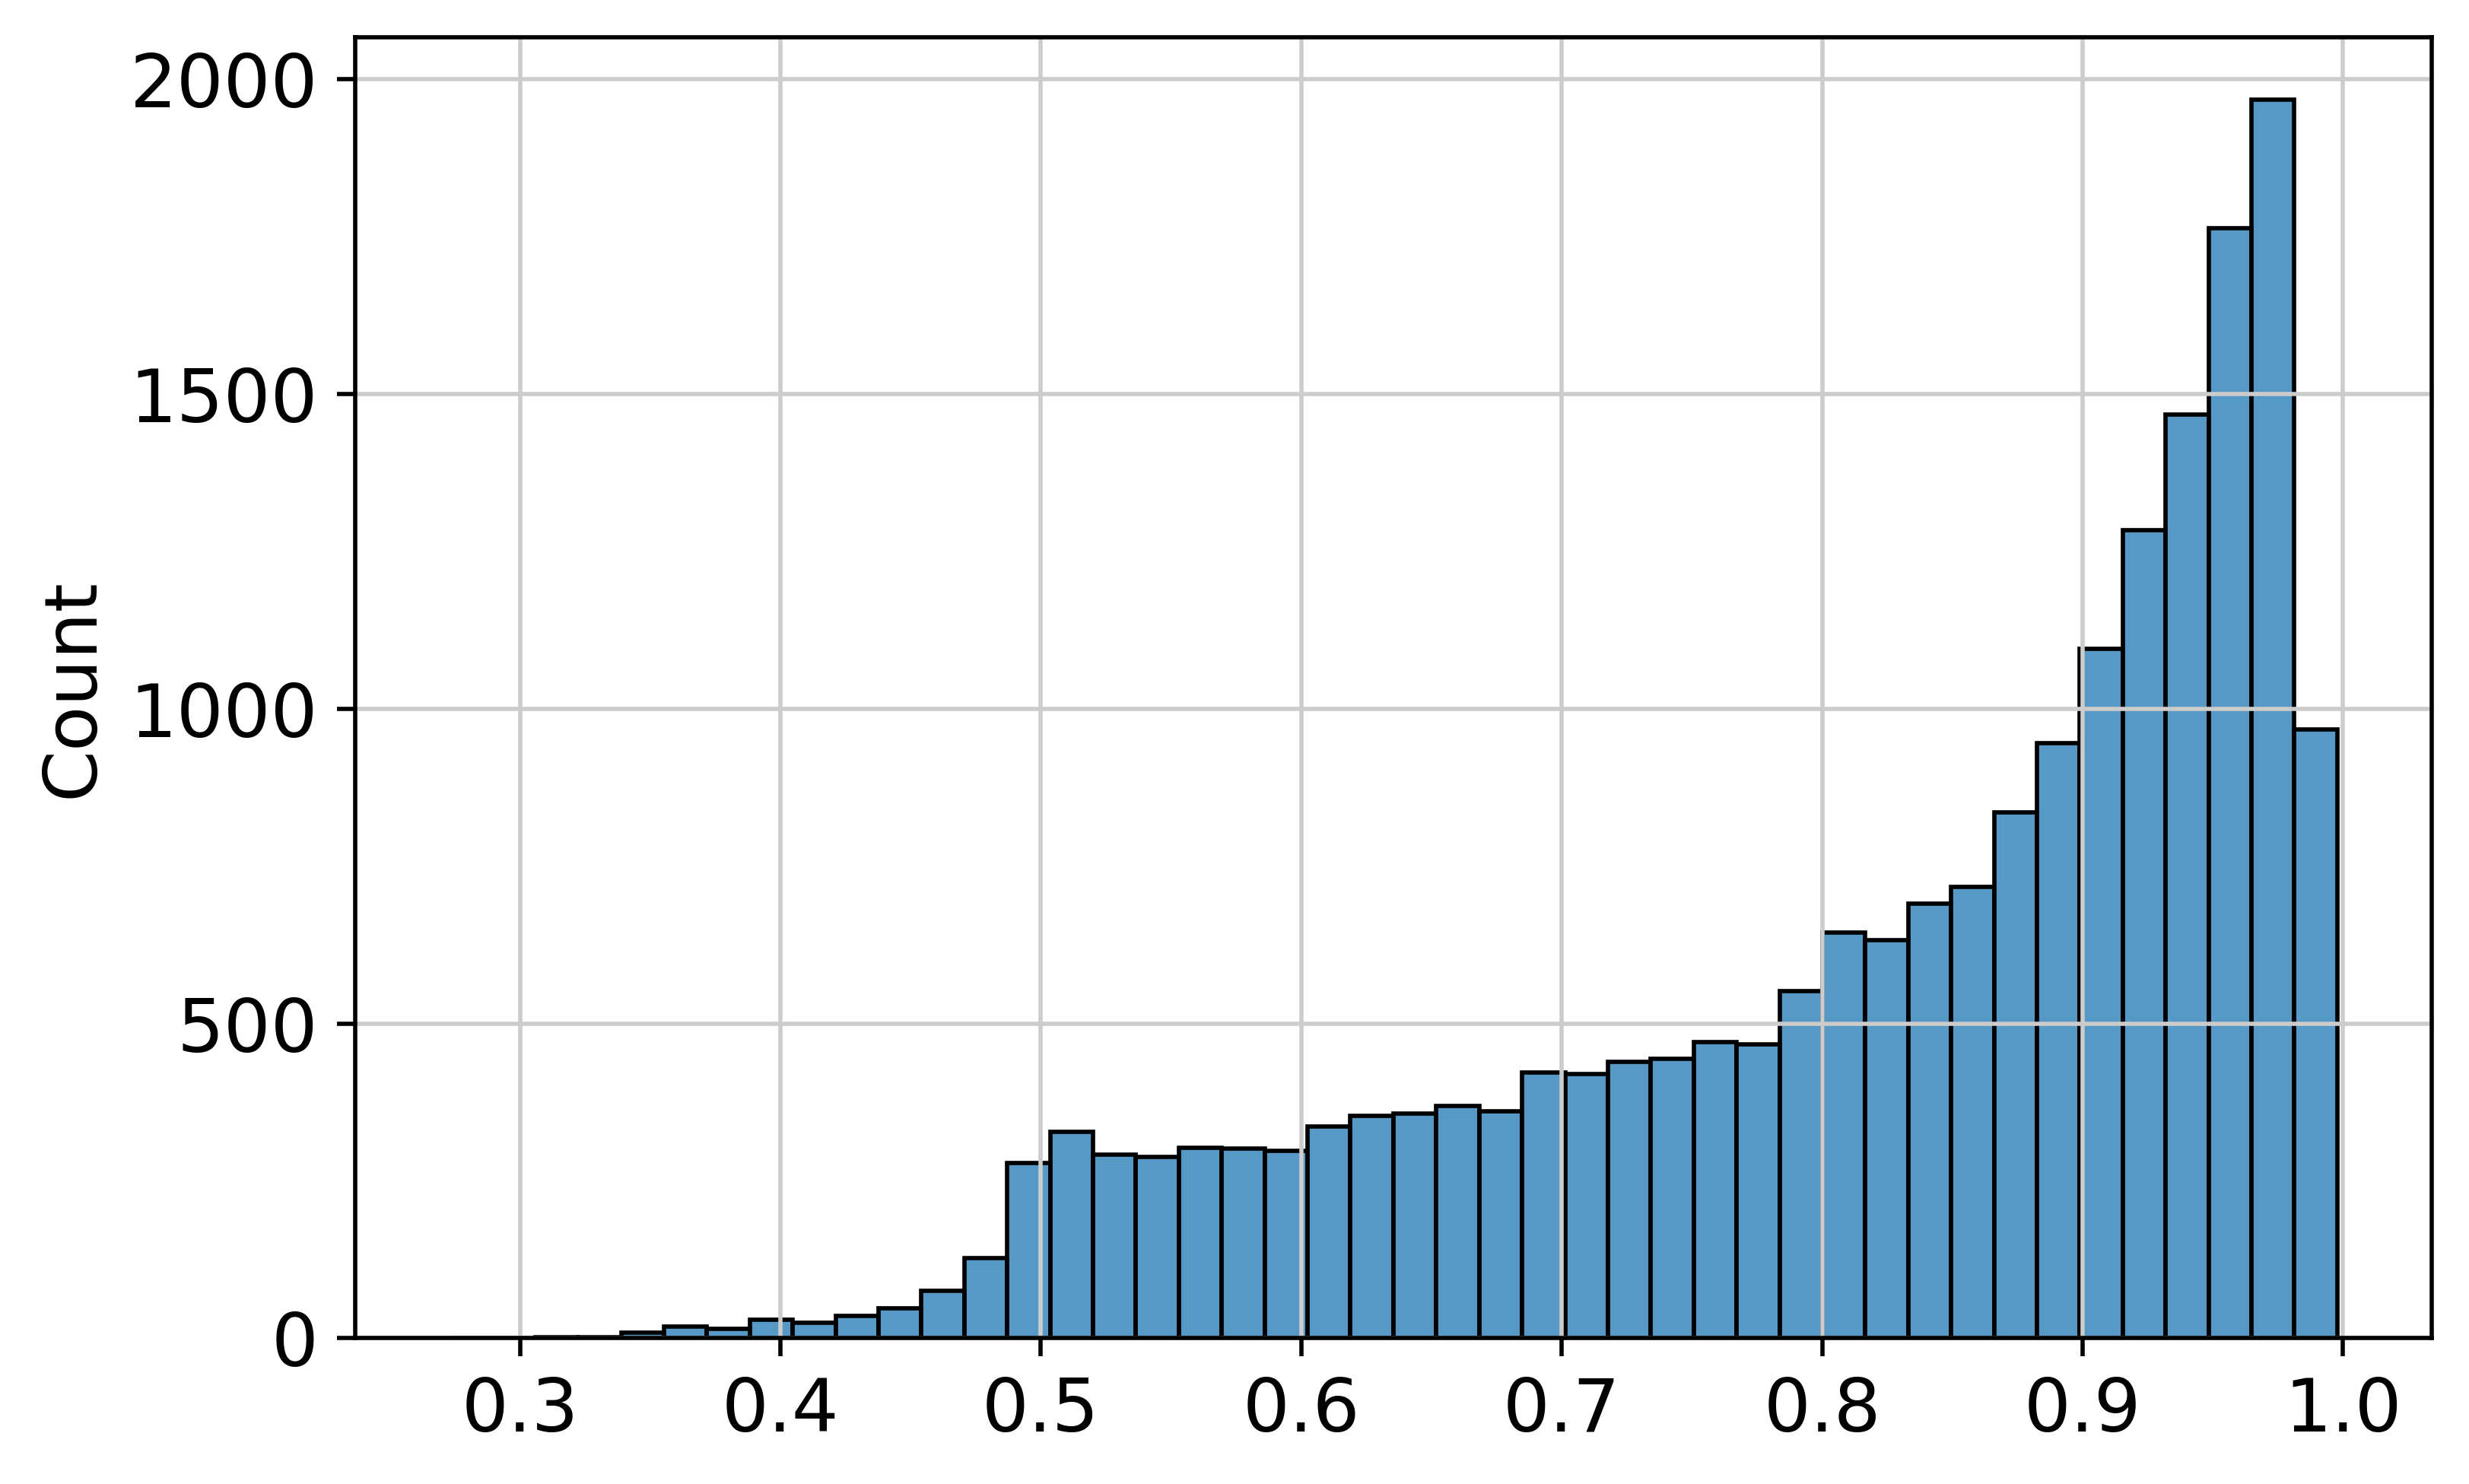

In [10]:
prob = []
for i in range(len(predicted1)):
  predicted1[i] = Classifier1[i].predict(data1[i][1])
  prob.append(np.max(Classifier1[i].predict_proba(data1[i][1]), axis = 1))

p = np.vstack(prob).flatten()
sns.histplot(p)

In [11]:
acc1n = []
f1_sep1n = []
f1_all1n = []

for i in range(len(predicted1)):
  predicted1[i] = Classifier1[i].predict(data1[i][1])

  prob = np.max(Classifier1[i].predict_proba(data1[i][1]), axis = 1)
  unlabeled = np.where(prob < 0.48)
  predicted1[i][unlabeled] = 'Unknown'

  ### Avaliação do modelo
  # Acurácia
  acc1n.append(Classifier1[i].score(data1[i][1], data1[i][3]))
  # F1
  f1_sep1n.append(metrics.f1_score(data1[i][3], predicted1[i], average=None))
  f1_all1n.append(metrics.f1_score(data1[i][3], predicted1[i], average="macro"))


In [41]:
results1 = pd.DataFrame({"Acurácia": acc1n, "F1_all": f1_all1n}, index= ["Fold " + str(i+1) for i in range(5)])

f1_sep1nf = []
for x in range(5):
  f1_sep1nf.append([f1_sep1n[x][i] for i in range(len(classes)+1) if i!=3])

for i in range(len(classes)):
  results1["F1_" + classes[i]] = [f1_sep1nf[x][i] for x in range(5)]

display(results1)

display(results1.describe())

,Acurácia,F1_all,F1_Acinar,F1_Alpha,F1_Beta,F1_delta,F1_duct,F1_pp,F1_psc
Fold 1,0.874969,0.684699,0.782609,0.889874,0.867526,0.573529,0.944134,0.444444,0.975477
Fold 2,0.876190,0.641370,0.555556,0.895464,0.872097,0.541353,0.950276,0.340741,0.975477
Fold 3,0.888889,0.701578,0.869565,0.900718,0.889253,0.639456,0.946779,0.382979,0.983871
Fold 4,0.883272,0.694753,0.869565,0.896280,0.882024,0.619718,0.952646,0.364964,0.972826
Fold 5,0.873504,0.678260,0.761905,0.891347,0.865347,0.594203,0.937853,0.397163,0.978261


,Acurácia,F1_all,F1_Acinar,F1_Alpha,F1_Beta,F1_delta,F1_duct,F1_pp,F1_psc
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.879365,0.680132,0.767840,0.894737,0.875249,0.593652,0.946338,0.386058,0.977182
std,0.006514,0.023455,0.128466,0.004296,0.010120,0.038464,0.005752,0.038860,0.004204
min,0.873504,0.641370,0.555556,0.889874,0.865347,0.541353,0.937853,0.340741,0.972826
25%,0.874969,0.678260,0.761905,0.891347,0.867526,0.573529,0.944134,0.364964,0.975477
50%,0.876190,0.684699,0.782609,0.895464,0.872097,0.594203,0.946779,0.382979,0.975477
75%,0.883272,0.694753,0.869565,0.896280,0.882024,0.619718,0.950276,0.397163,0.978261
max,0.888889,0.701578,0.869565,0.900718,0.889253,0.639456,0.952646,0.444444,0.983871


In [13]:
all_pred1 = np.concatenate(predicted1).ravel()
all_true1 = np.concatenate([data1[i][3] for i in range(5)]).ravel()
mat1 = metrics.confusion_matrix(all_pred1, all_true1)

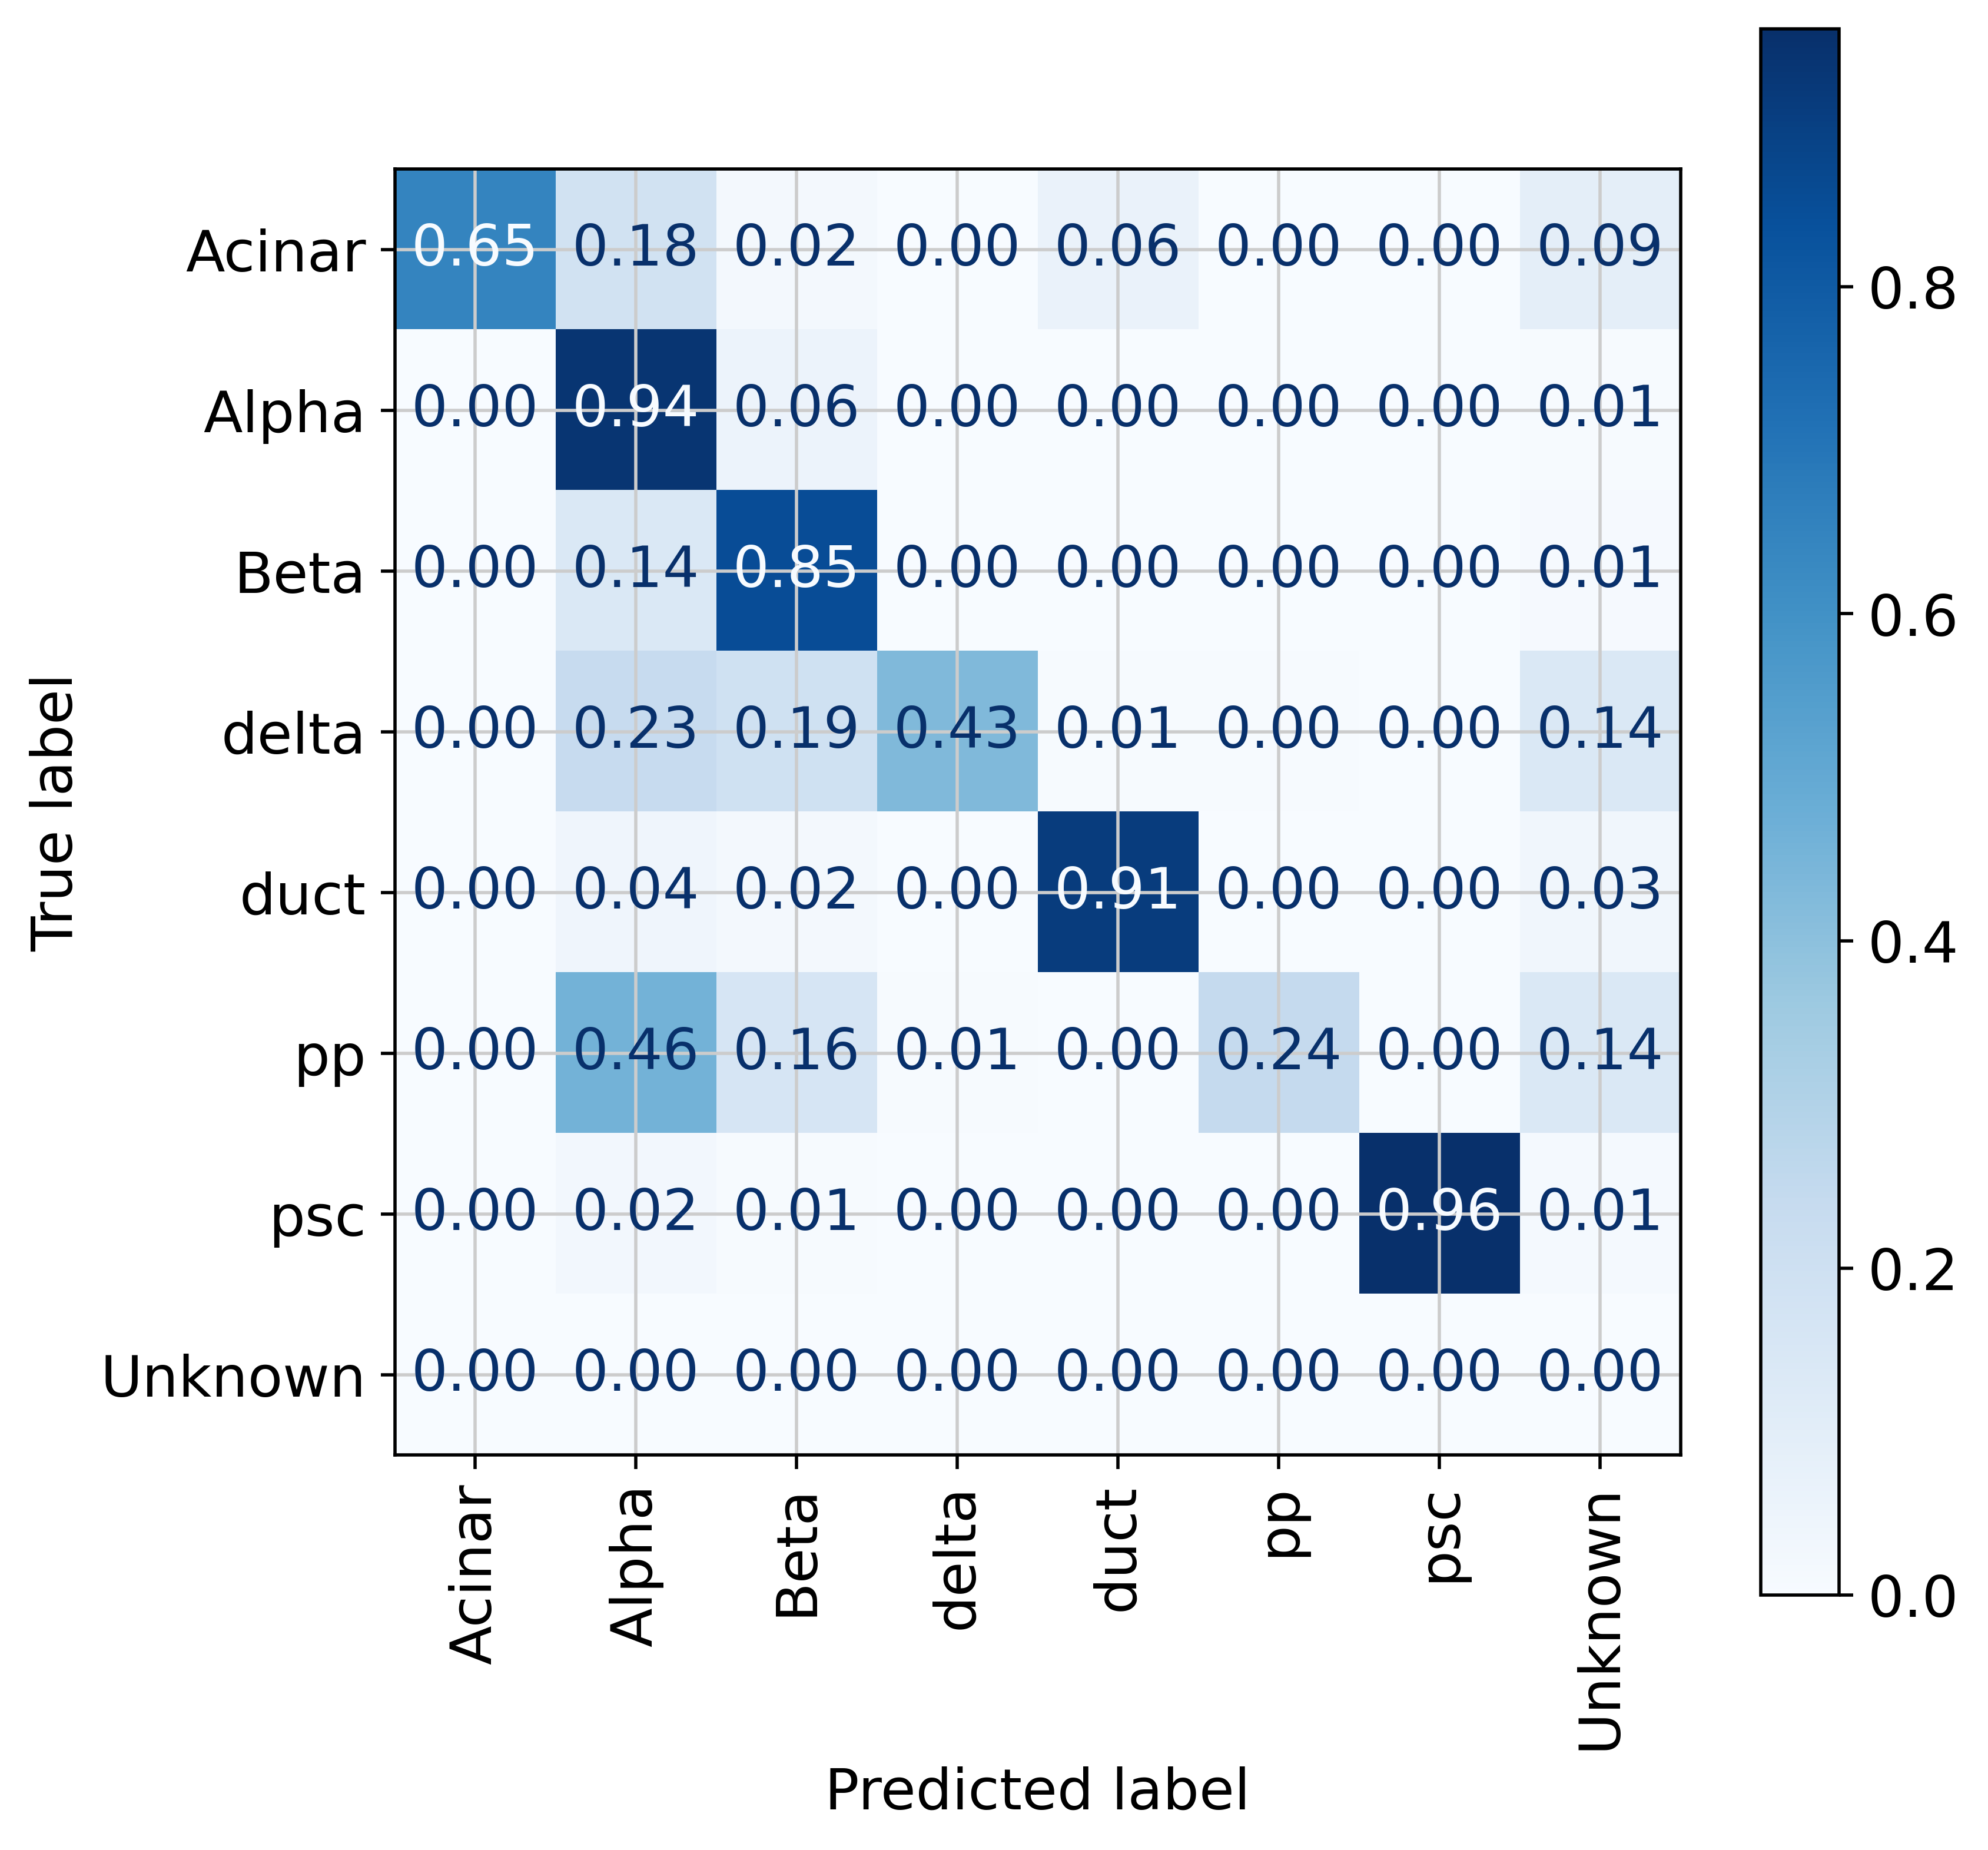

In [14]:
fig, ax = plt.subplots(figsize=(7,7))
disp = metrics.ConfusionMatrixDisplay.from_predictions(
    y_true=all_true1,
    y_pred=all_pred1,
    labels=classes + ["Unknown"],
    cmap=plt.cm.Blues,
    normalize="true",
    values_format='.2f',
    xticks_rotation="vertical",
    ax=ax
)


## Modelo 2: Treino D, Teste D

In [15]:
dados2 = adata[adata.obs.Donor.isin(d)].copy()
dados2

AnnData object with n_obs × n_vars = 5617 × 3447
    obs: 'Donor', 'Celltype', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Celltype_colors', 'Donor_colors', 'hvg', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [16]:
Classifier2 = []
data2 = []

predicted2 = []
acc2 = []
f1_sep2 = []
f1_all2 = []

In [17]:
for k in range(5):

  # Separação dos dados
  X_train2, X_test2, y_train2, y_test2 = train_test_split(dados2.X, dados2.obs.Celltype, test_size=0.2, random_state=k, stratify=dados2.obs.Celltype)
  data2.append((X_train2, X_test2, y_train2, y_test2))

  if k==0:
    test = []
    train = []
    for i in classes:
      train.append(len([j for j in y_train2 if j==i]))
      test.append(len([j for j in y_test2 if j==i]))

    display(pd.DataFrame({"Train": train, "Test": test}, index=classes))

  # Treinamento
  Classifier = LinearSVC(max_iter=5000)
  Classifier2.append(CalibratedClassifierCV(Classifier))
  Classifier2[-1].fit(X_train2, y_train2)

  # Teste
  predicted2.append(Classifier2[-1].predict(X_test2))

  ### Avaliação do modelo
  # Acurácia
  acc2.append(Classifier2[-1].score(X_test2, y_test2))
  # F1
  f1_sep2.append(metrics.f1_score(y_test2, predicted2[-1], average=None))
  f1_all2.append(metrics.f1_score(y_test2, predicted2[-1], average="macro"))


,Train,Test
Acinar,17,5
Alpha,2434,609
Beta,1444,361
delta,105,26
duct,272,68
pp,64,16
psc,157,39


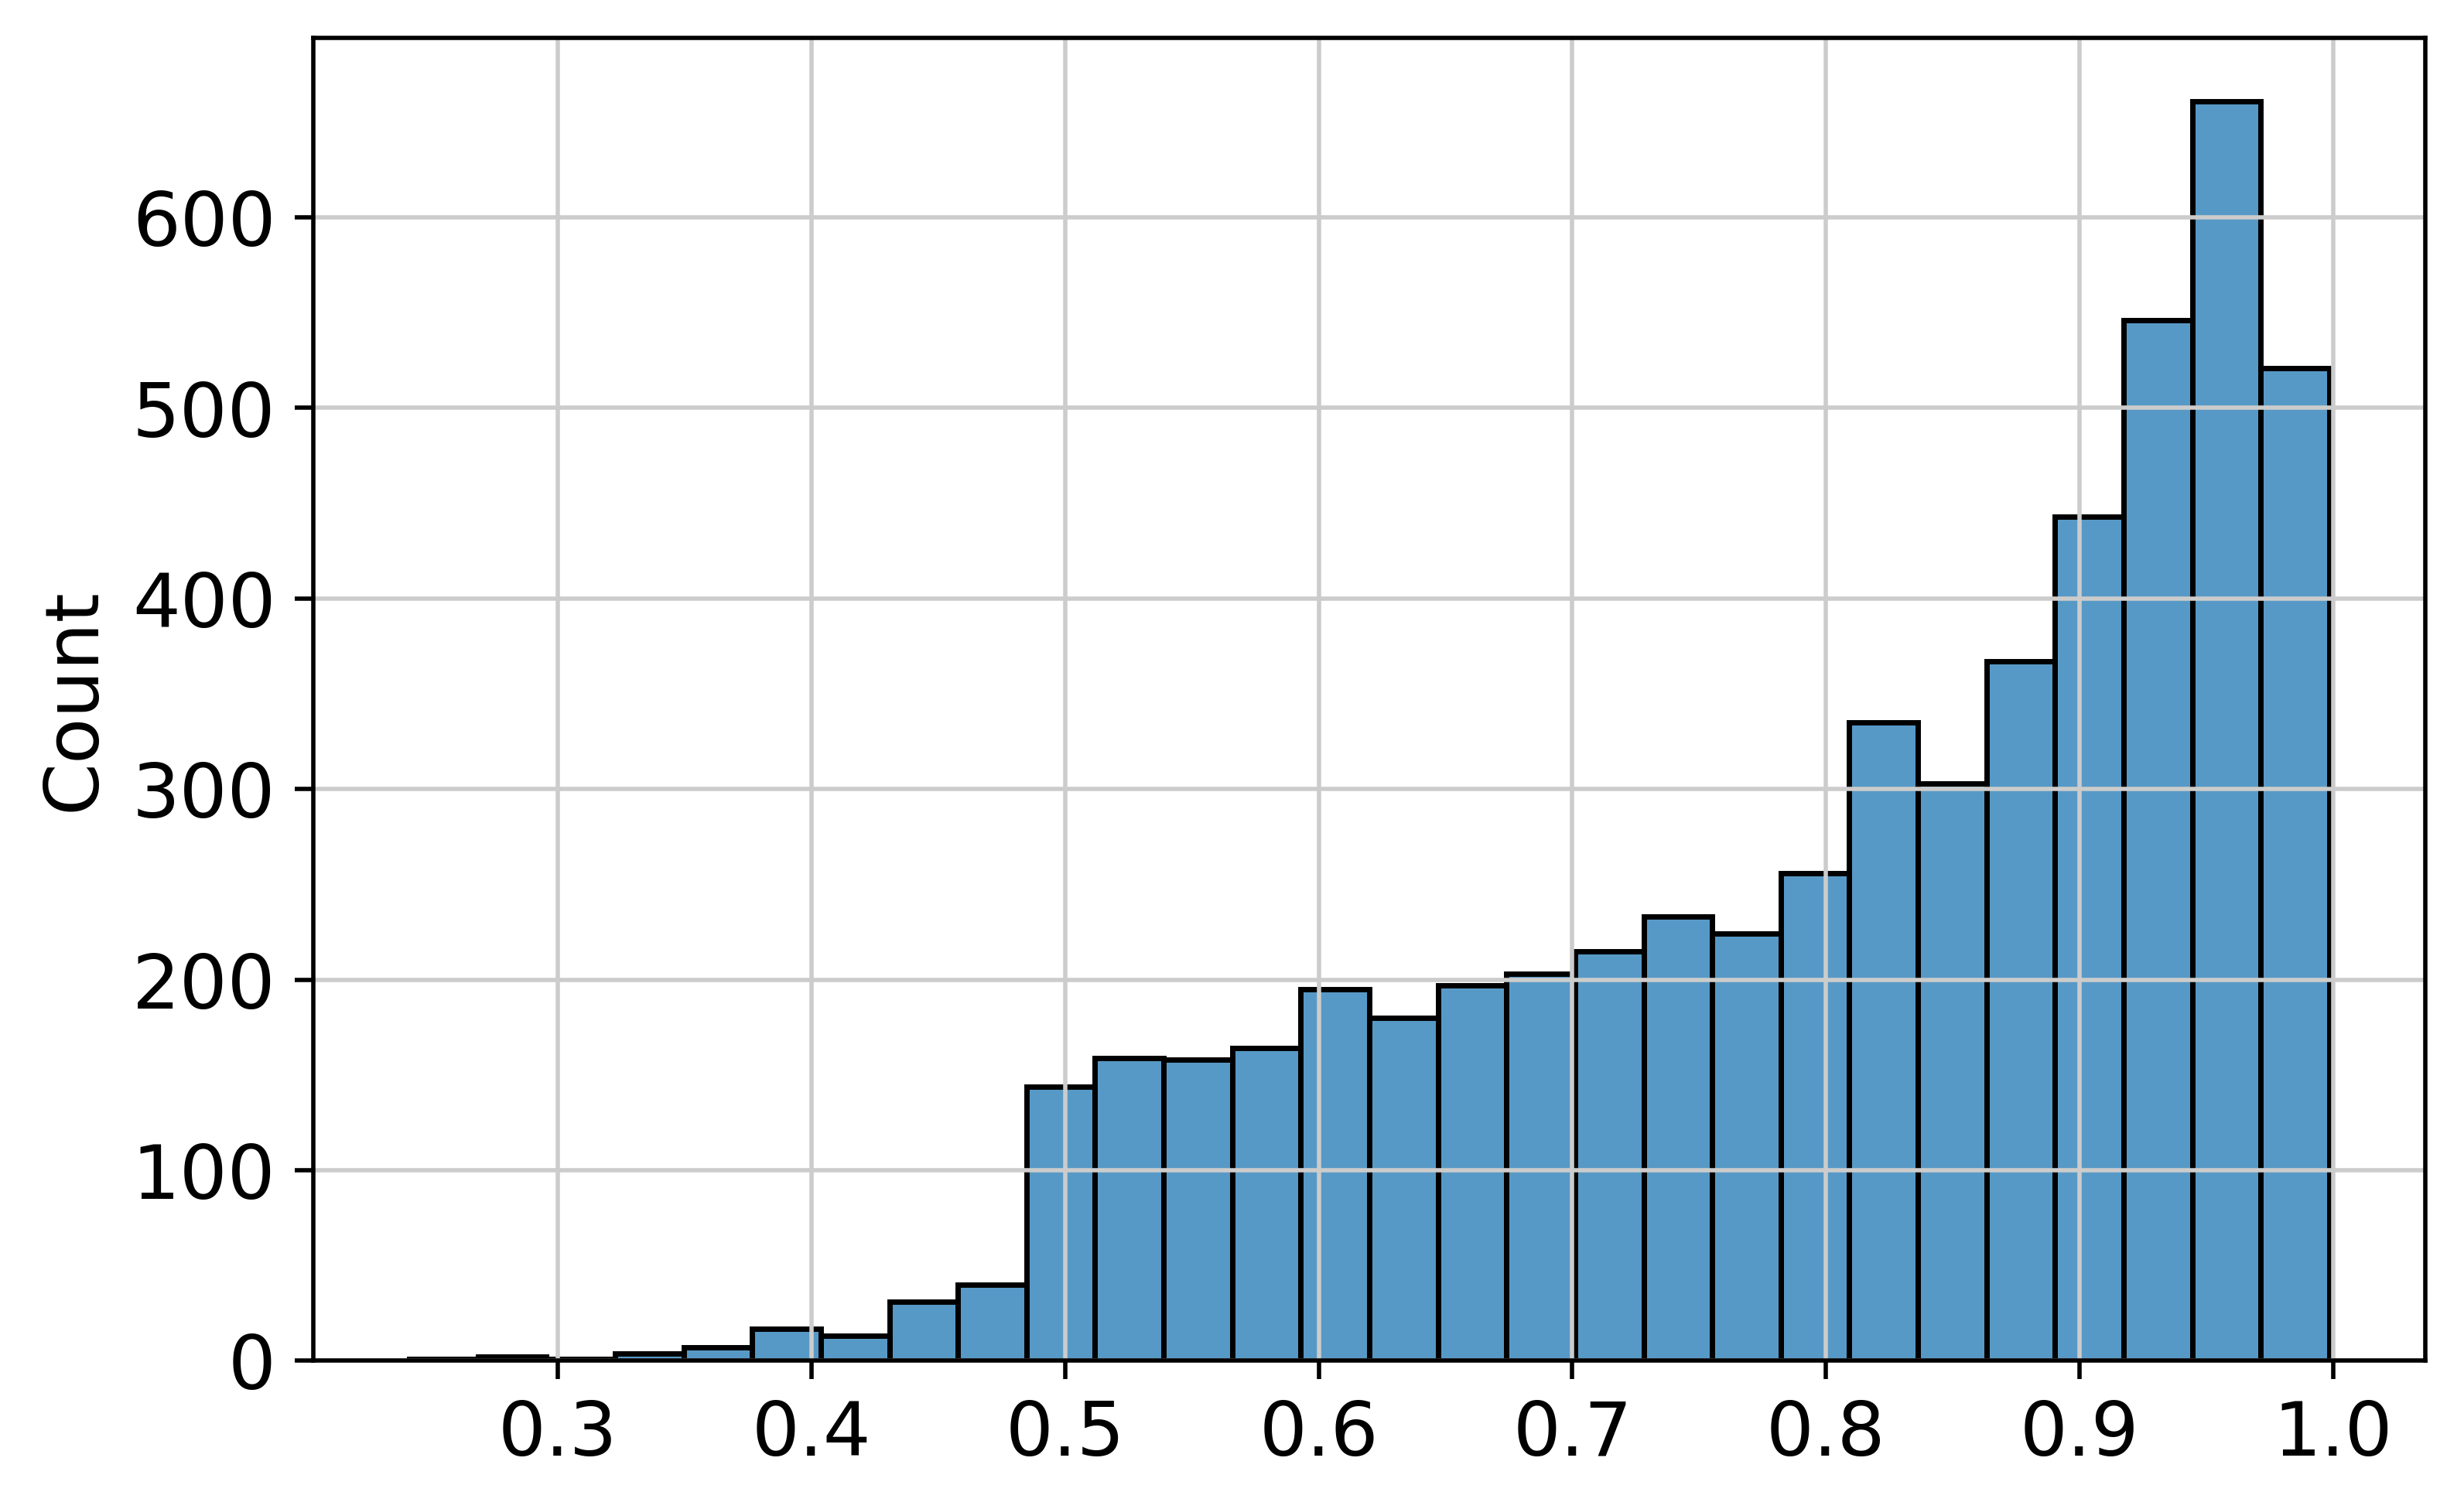

In [18]:
prob = []
for i in range(len(predicted2)):
  predicted2[i] = Classifier2[i].predict(data2[i][1])
  prob.append(np.max(Classifier2[i].predict_proba(data2[i][1]), axis = 1))

p = np.vstack(prob).flatten()
sns.histplot(p)

In [42]:
results2 = pd.DataFrame({"Acurácia": acc2, "F1_all": f1_all2}, index= ["Fold " + str(i+1) for i in range(5)])

for i in range(len(classes)):
  results2["F1_" + classes[i]] = [f1_sep2[x][i] for x in range(5)]

display(results2)

display(results2.describe())

,Acurácia,F1_all,F1_Acinar,F1_Alpha,F1_Beta,F1_delta,F1_duct,F1_pp,F1_psc
Fold 1,0.854093,0.648507,0.750000,0.887172,0.813853,0.206897,0.946565,0.000000,0.935065
Fold 2,0.842527,0.624084,0.750000,0.876543,0.802309,0.074074,0.932331,0.000000,0.933333
Fold 3,0.832740,0.636877,0.571429,0.869632,0.770132,0.206897,0.962406,0.117647,0.960000
Fold 4,0.860320,0.646749,0.571429,0.890101,0.813754,0.266667,0.985294,0.000000,1.000000
Fold 5,0.853203,0.588917,0.333333,0.885271,0.822191,0.206897,0.914729,0.000000,0.960000


,Acurácia,F1_all,F1_Acinar,F1_Alpha,F1_Beta,F1_delta,F1_duct,F1_pp,F1_psc
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.848577,0.629027,0.595238,0.881744,0.804448,0.192286,0.948265,0.023529,0.957680
std,0.010922,0.024436,0.171486,0.008448,0.020445,0.070970,0.027169,0.052613,0.026953
min,0.832740,0.588917,0.333333,0.869632,0.770132,0.074074,0.914729,0.000000,0.933333
25%,0.842527,0.624084,0.571429,0.876543,0.802309,0.206897,0.932331,0.000000,0.935065
50%,0.853203,0.636877,0.571429,0.885271,0.813754,0.206897,0.946565,0.000000,0.960000
75%,0.854093,0.646749,0.750000,0.887172,0.813853,0.206897,0.962406,0.000000,0.960000
max,0.860320,0.648507,0.750000,0.890101,0.822191,0.266667,0.985294,0.117647,1.000000


In [20]:
acc2n = []
f1_sep2n = []
f1_all2n = []

for i in range(len(predicted2)):
  predicted2[i] = Classifier2[i].predict(data2[i][1])

  prob = np.max(Classifier2[i].predict_proba(data2[i][1]), axis = 1)
  unlabeled = np.where(prob < 0.48)
  predicted2[i][unlabeled] = 'Unknown'

  ### Avaliação do modelo
  # Acurácia
  acc2n.append(Classifier2[i].score(data2[i][1], data2[i][3]))
  # F1
  f1_sep2n.append(metrics.f1_score(data2[i][3], predicted2[i], average=None))
  f1_all2n.append(metrics.f1_score(data2[i][3], predicted2[i], average="macro"))


In [43]:
results2 = pd.DataFrame({"Acurácia": acc2n, "F1_all": f1_all2n}, index= ["Fold " + str(i+1) for i in range(5)])

f1_sep2nf = []
for x in range(5):
  f1_sep2nf.append([f1_sep2n[x][i] for i in range(len(classes)+1) if i!=3])
for i in range(len(classes)):
  results2["F1_" + classes[i]] = [f1_sep2nf[x][i] for x in range(5)]

display(results2)

display(results2.describe())

,Acurácia,F1_all,F1_Acinar,F1_Alpha,F1_Beta,F1_delta,F1_duct,F1_pp,F1_psc
Fold 1,0.854093,0.561435,0.750000,0.888889,0.809942,0.142857,0.953846,0.0,0.945946
Fold 2,0.842527,0.544385,0.750000,0.879377,0.798246,0.074074,0.921875,0.0,0.931507
Fold 3,0.832740,0.532922,0.571429,0.870370,0.770370,0.142857,0.962406,0.0,0.945946
Fold 4,0.860320,0.509362,0.333333,0.890809,0.817919,0.074074,0.985075,0.0,0.973684
Fold 5,0.853203,0.499632,0.333333,0.885425,0.822350,0.074074,0.921875,0.0,0.960000


,Acurácia,F1_all,F1_Acinar,F1_Alpha,F1_Beta,F1_delta,F1_duct,F1_pp,F1_psc
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.0,5.000000
mean,0.848577,0.529547,0.547619,0.882974,0.803765,0.101587,0.949015,0.0,0.951417
std,0.010922,0.025252,0.208758,0.008279,0.020794,0.037674,0.027277,0.0,0.016014
min,0.832740,0.499632,0.333333,0.870370,0.770370,0.074074,0.921875,0.0,0.931507
25%,0.842527,0.509362,0.333333,0.879377,0.798246,0.074074,0.921875,0.0,0.945946
50%,0.853203,0.532922,0.571429,0.885425,0.809942,0.074074,0.953846,0.0,0.945946
75%,0.854093,0.544385,0.750000,0.888889,0.817919,0.142857,0.962406,0.0,0.960000
max,0.860320,0.561435,0.750000,0.890809,0.822350,0.142857,0.985075,0.0,0.973684


In [22]:
all_pred2 = np.concatenate(predicted2).ravel()
all_true2 = np.concatenate([data2[i][3] for i in range(5)]).ravel()
mat2 = metrics.confusion_matrix(all_pred2, all_true2)

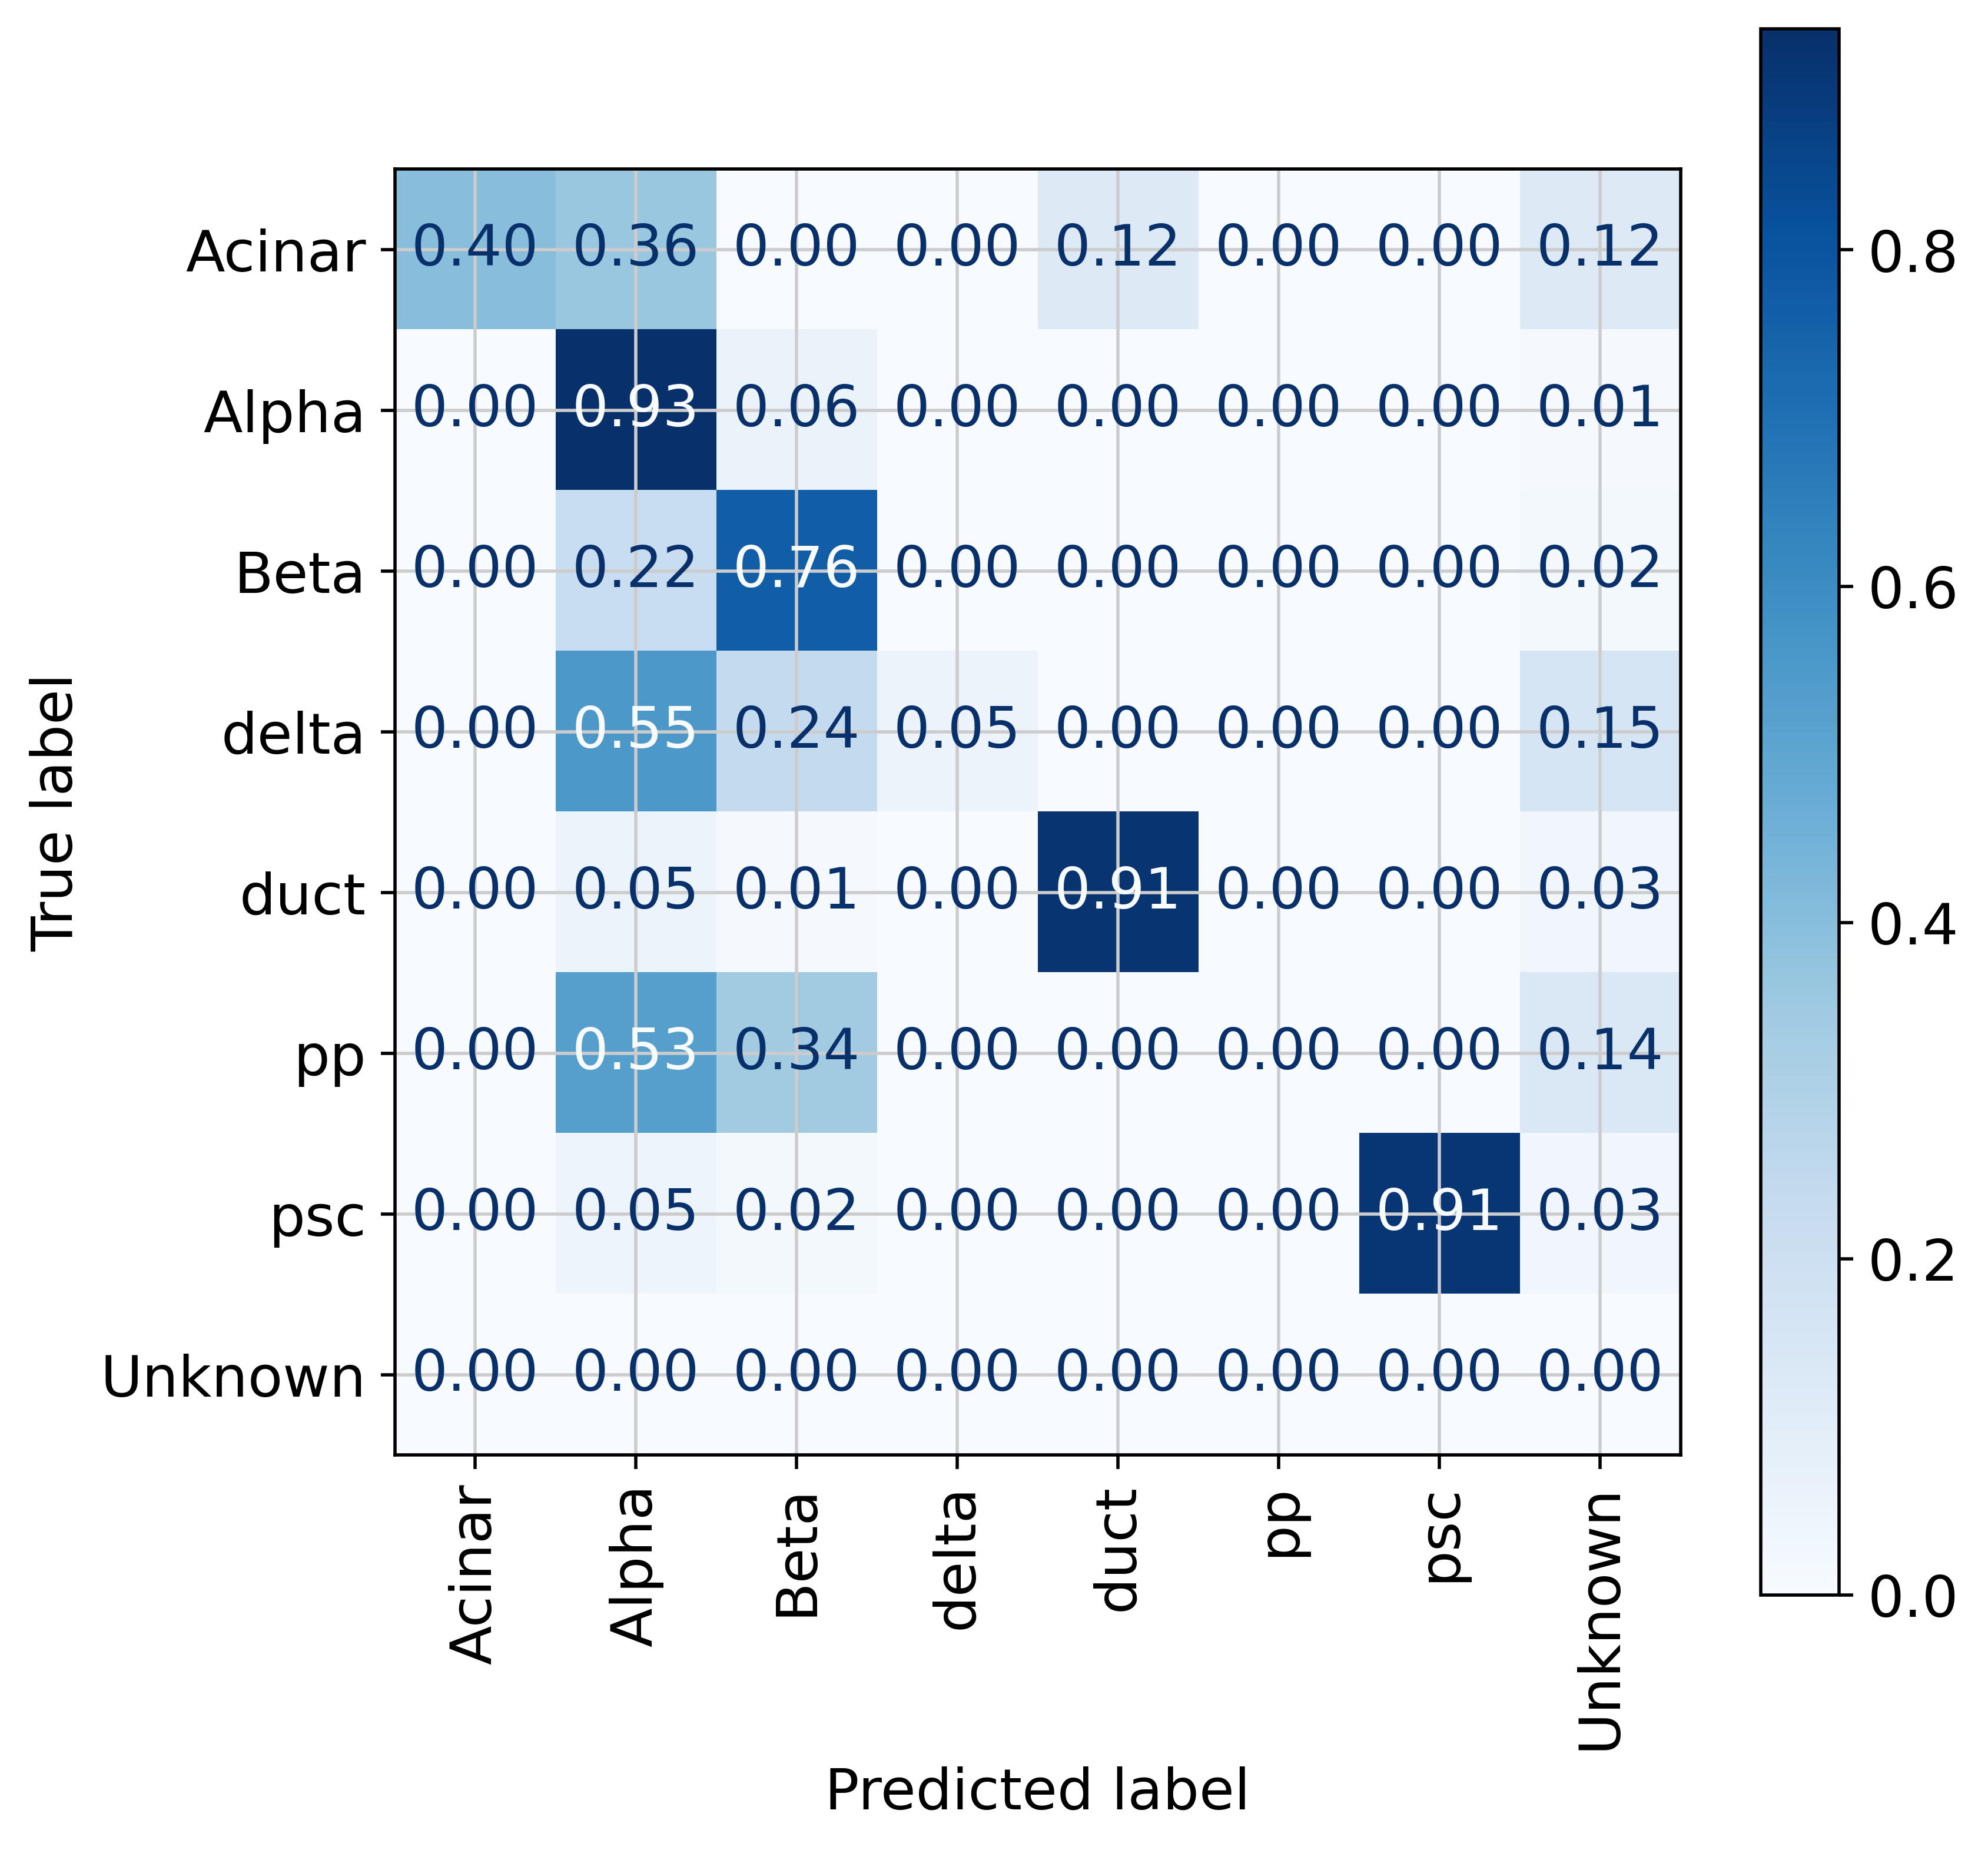

In [23]:
fig, ax = plt.subplots(figsize=(7,7))
disp = metrics.ConfusionMatrixDisplay.from_predictions(
    y_true=all_true2,
    y_pred=all_pred2,
    labels=classes + ["Unknown"],
    cmap=plt.cm.Blues,
    normalize="true",
    values_format='.2f',
    xticks_rotation="vertical",
    ax=ax
)


## Modelo 3: Treino H, Teste D

In [24]:
data3 = []

predicted3 = []
acc3 = []
f1_sep3 = []
f1_all3 = []

In [25]:
for k in range(5):

  # Separação dos dados
  X_test3, _, y_test3, _ = train_test_split(dados2.X, dados2.obs.Celltype, test_size=0.2, random_state=k, stratify=dados2.obs.Celltype)
  data3.append((X_test3, y_test3))

  if k==0:
    test = []
    train = []
    for i in classes:
      train.append(len([j for j in data1[k][2] if j==i]))
      test.append(len([j for j in y_test3 if j==i]))

    display(pd.DataFrame({"Train": train, "Test": test}, index=classes))

  # Teste
  predicted3.append(Classifier1[k].predict(X_test3))

  ### Avaliação do modelo
  # Acurácia
  acc3.append(Classifier1[k].score(X_test3, y_test3))
  # F1
  f1_sep3.append(metrics.f1_score(y_test3, predicted3[-1], average=None))
  f1_all3.append(metrics.f1_score(y_test3, predicted3[-1], average="macro"))


,Train,Test
Acinar,54,17
Alpha,7748,2434
Beta,6245,1444
delta,389,105
duct,742,272
pp,450,64
psc,751,157


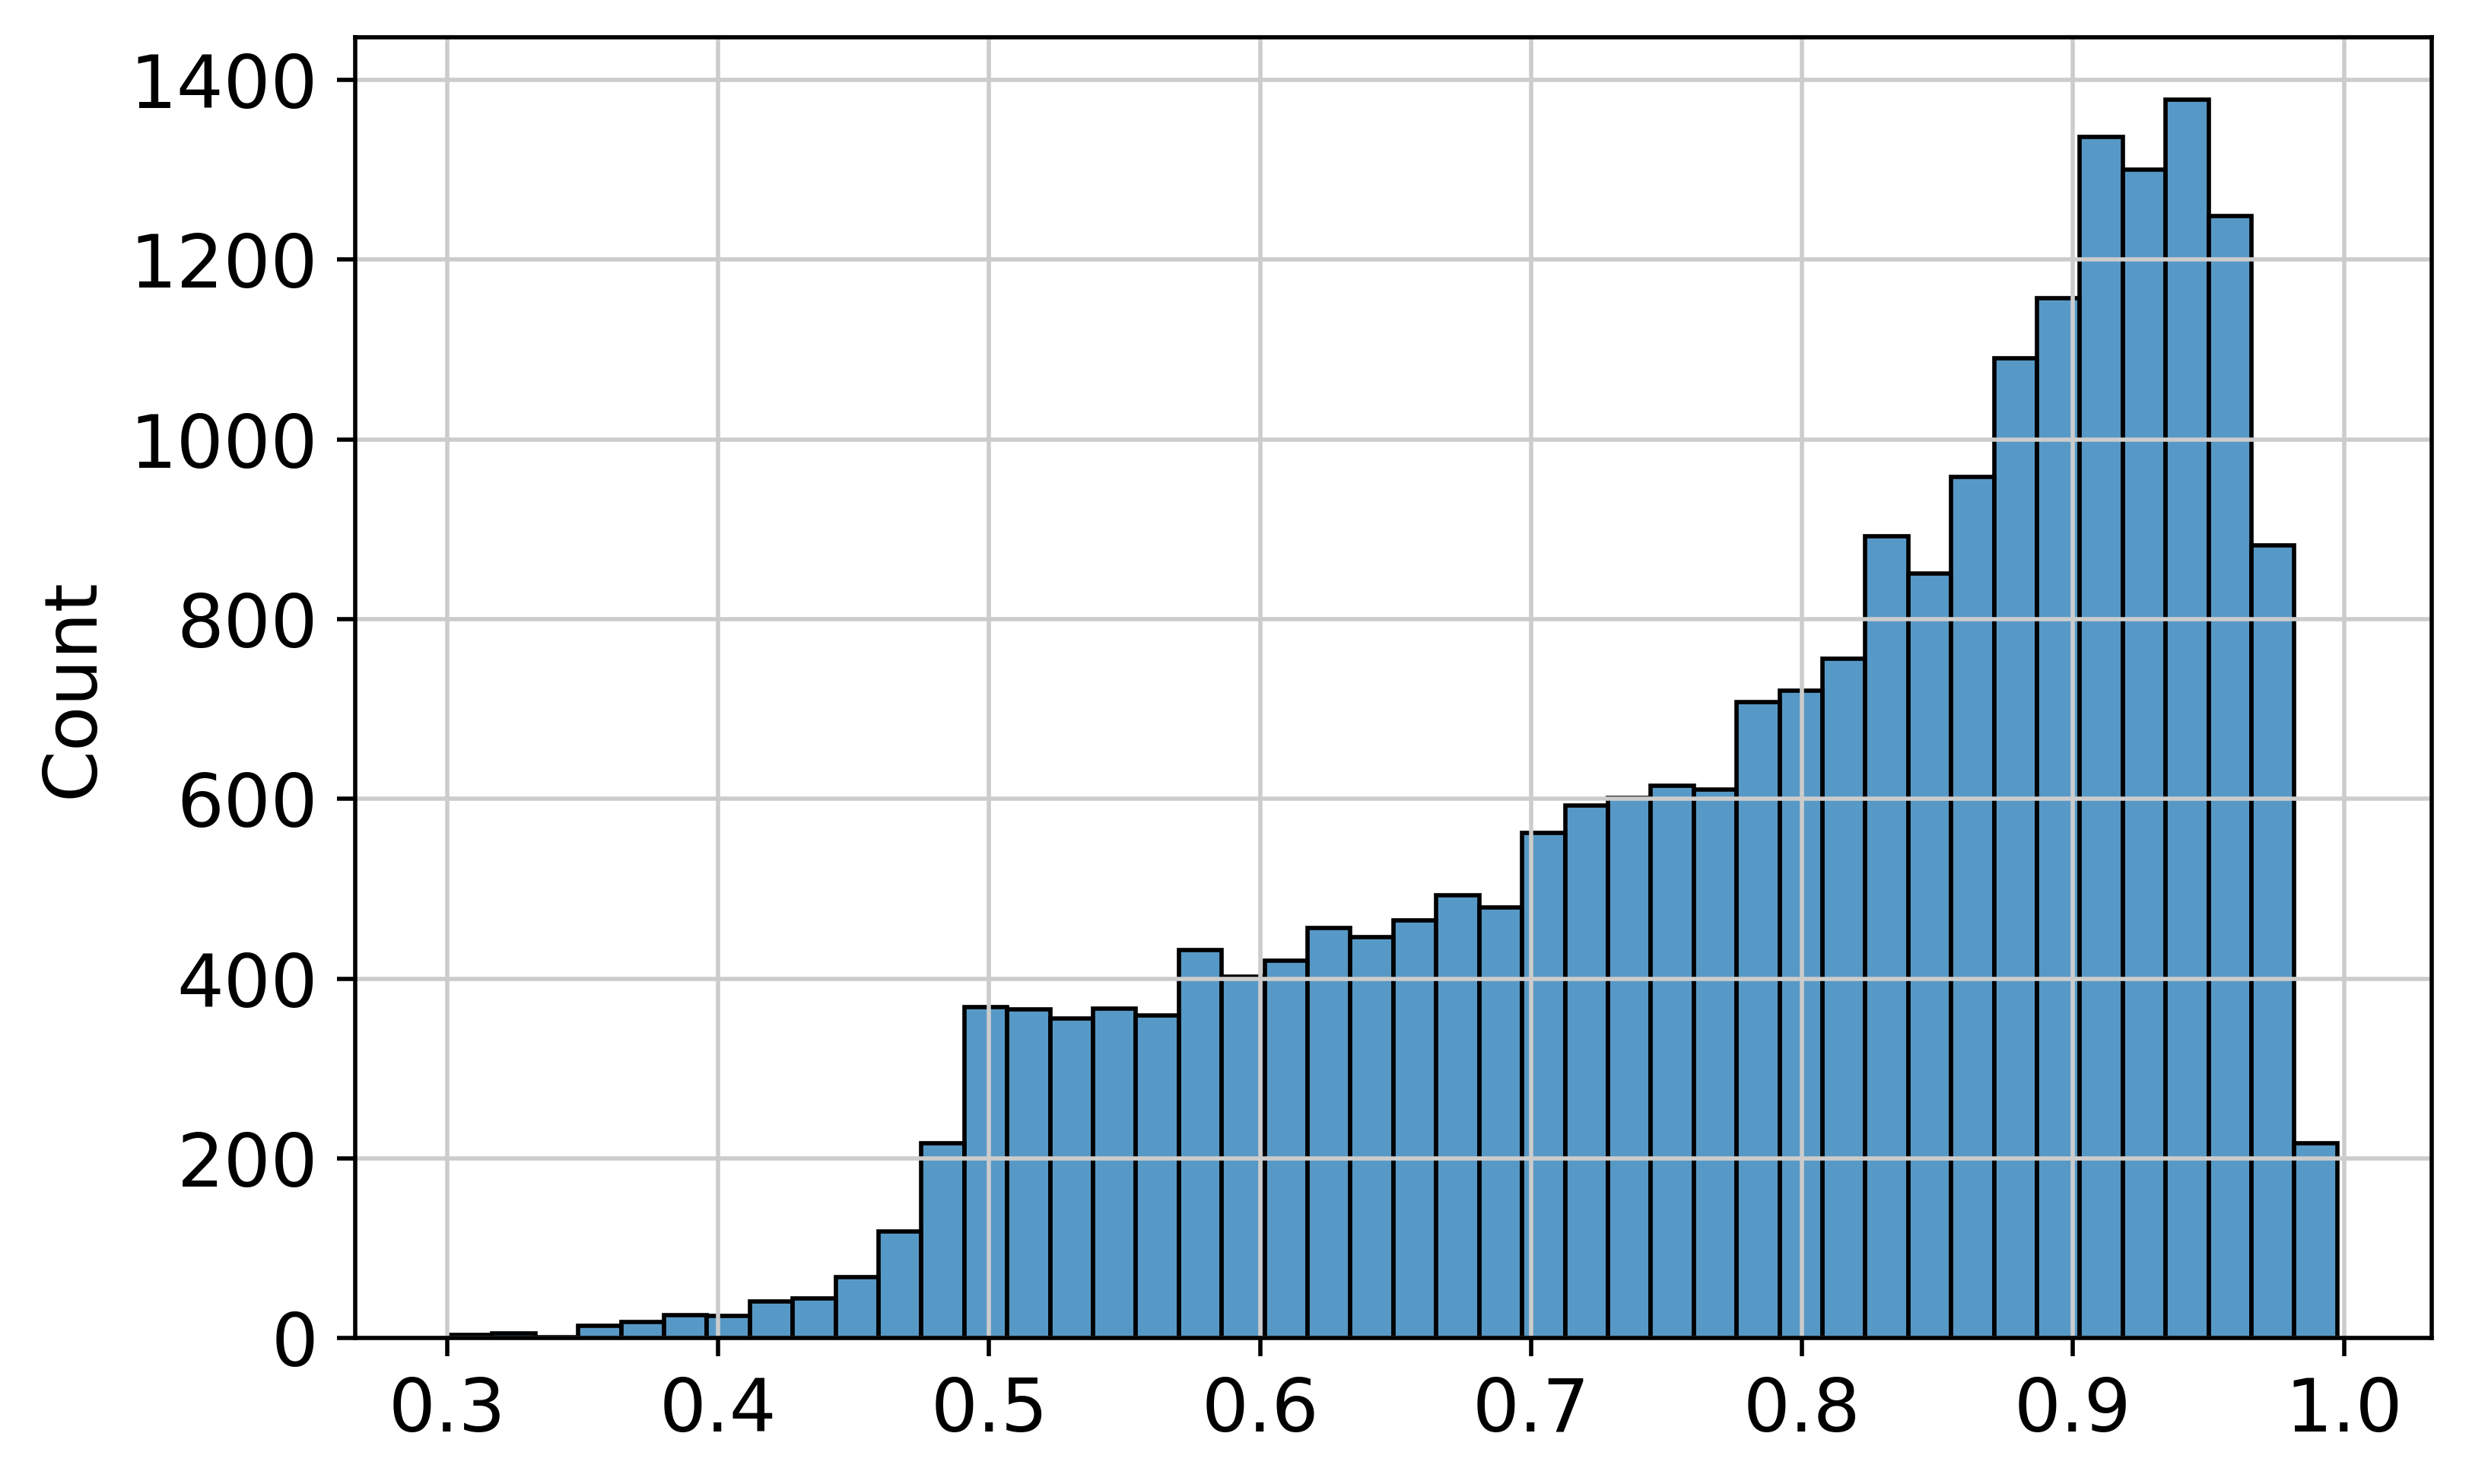

In [26]:
prob = []
for i in range(len(predicted3)):
  predicted3[i] = Classifier1[i].predict(data3[i][0])
  prob.append(np.max(Classifier1[i].predict_proba(data3[i][0]), axis = 1))

p = np.vstack(prob).flatten()
sns.histplot(p)

In [27]:
results3 = pd.DataFrame({"Acurácia": acc3, "F1_all": f1_all3}, index= ["Fold " + str(i+1) for i in range(5)])

for i in range(len(classes)):
  results3["F1_" + classes[i]] = [f1_sep3[x][i] for x in range(5)]

display(results3)

display(results3.describe())

,Acurácia,F1_all,F1_Acinar,F1_Alpha,F1_Beta,F1_delta,F1_duct,F1_pp,F1_psc
Fold 1,0.873136,0.782909,0.937500,0.898752,0.833860,0.506849,0.954373,0.375000,0.974026
Fold 2,0.870243,0.773965,0.903226,0.895892,0.829217,0.520548,0.962264,0.329114,0.977492
Fold 3,0.877142,0.786268,0.937500,0.902078,0.842324,0.500000,0.944338,0.400000,0.977636
Fold 4,0.874917,0.788239,0.969697,0.899724,0.839349,0.500000,0.940952,0.400000,0.967949
Fold 5,0.877587,0.799999,0.969697,0.901342,0.839716,0.524138,0.958333,0.439024,0.967742


,Acurácia,F1_all,F1_Acinar,F1_Alpha,F1_Beta,F1_delta,F1_duct,F1_pp,F1_psc
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.874605,0.786276,0.943524,0.899557,0.836893,0.510307,0.952052,0.388628,0.972969
std,0.003026,0.009422,0.027688,0.002432,0.005282,0.011408,0.009108,0.040392,0.004896
min,0.870243,0.773965,0.903226,0.895892,0.829217,0.500000,0.940952,0.329114,0.967742
25%,0.873136,0.782909,0.937500,0.898752,0.833860,0.500000,0.944338,0.375000,0.967949
50%,0.874917,0.786268,0.937500,0.899724,0.839349,0.506849,0.954373,0.400000,0.974026
75%,0.877142,0.788239,0.969697,0.901342,0.839716,0.520548,0.958333,0.400000,0.977492
max,0.877587,0.799999,0.969697,0.902078,0.842324,0.524138,0.962264,0.439024,0.977636


In [28]:
acc3n = []
f1_sep3n = []
f1_all3n = []

for i in range(len(predicted3)):
  predicted3[i] = Classifier1[i].predict(data3[i][0])

  prob = np.max(Classifier1[i].predict_proba(data3[i][0]), axis = 1)
  unlabeled = np.where(prob < 0.48)
  predicted3[i][unlabeled] = 'Unknown'

  ### Avaliação do modelo
  # Acurácia
  acc3n.append(Classifier1[i].score(data3[i][0], data3[i][1]))
  # F1
  f1_sep3n.append(metrics.f1_score(data3[i][1], predicted3[i], average=None))
  f1_all3n.append(metrics.f1_score(data3[i][1], predicted3[i], average="macro"))


In [44]:
results3 = pd.DataFrame({"Acurácia": acc3n, "F1_all": f1_all3n}, index= ["Fold " + str(i+1) for i in range(5)])

f1_sep3nf = []
for x in range(5):
  f1_sep3nf.append([f1_sep3n[x][i] for i in range(len(classes)+1) if i!=3])
for i in range(len(classes)):
  results3["F1_" + classes[i]] = [f1_sep3nf[x][i] for x in range(5)]

display(results3)

display(results3.describe())

,Acurácia,F1_all,F1_Acinar,F1_Alpha,F1_Beta,F1_delta,F1_duct,F1_pp,F1_psc
Fold 1,0.873136,0.666807,0.937500,0.899181,0.835461,0.471429,0.950192,0.266667,0.974026
Fold 2,0.870243,0.665557,0.903226,0.896469,0.832688,0.446043,0.960152,0.311688,0.974194
Fold 3,0.877142,0.674578,0.937500,0.901369,0.844569,0.460432,0.937743,0.337662,0.977346
Fold 4,0.874917,0.669541,0.969697,0.899364,0.839356,0.449275,0.934615,0.293333,0.970684
Fold 5,0.877587,0.673787,0.937500,0.902957,0.838109,0.471429,0.954023,0.315789,0.970492


,Acurácia,F1_all,F1_Acinar,F1_Alpha,F1_Beta,F1_delta,F1_duct,F1_pp,F1_psc
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,0.874605,0.670054,0.937085,0.899868,0.838036,0.459721,0.947345,0.305028,0.973348
std,0.003026,0.004044,0.023508,0.002453,0.004463,0.011946,0.010851,0.026615,0.002847
min,0.870243,0.665557,0.903226,0.896469,0.832688,0.446043,0.934615,0.266667,0.970492
25%,0.873136,0.666807,0.937500,0.899181,0.835461,0.449275,0.937743,0.293333,0.970684
50%,0.874917,0.669541,0.937500,0.899364,0.838109,0.460432,0.950192,0.311688,0.974026
75%,0.877142,0.673787,0.937500,0.901369,0.839356,0.471429,0.954023,0.315789,0.974194
max,0.877587,0.674578,0.969697,0.902957,0.844569,0.471429,0.960152,0.337662,0.977346


In [30]:
all_pred3 = np.concatenate(predicted3).ravel()
all_true3 = np.concatenate([data3[i][1] for i in range(5)]).ravel()
mat3 = metrics.confusion_matrix(all_pred3, all_true3)

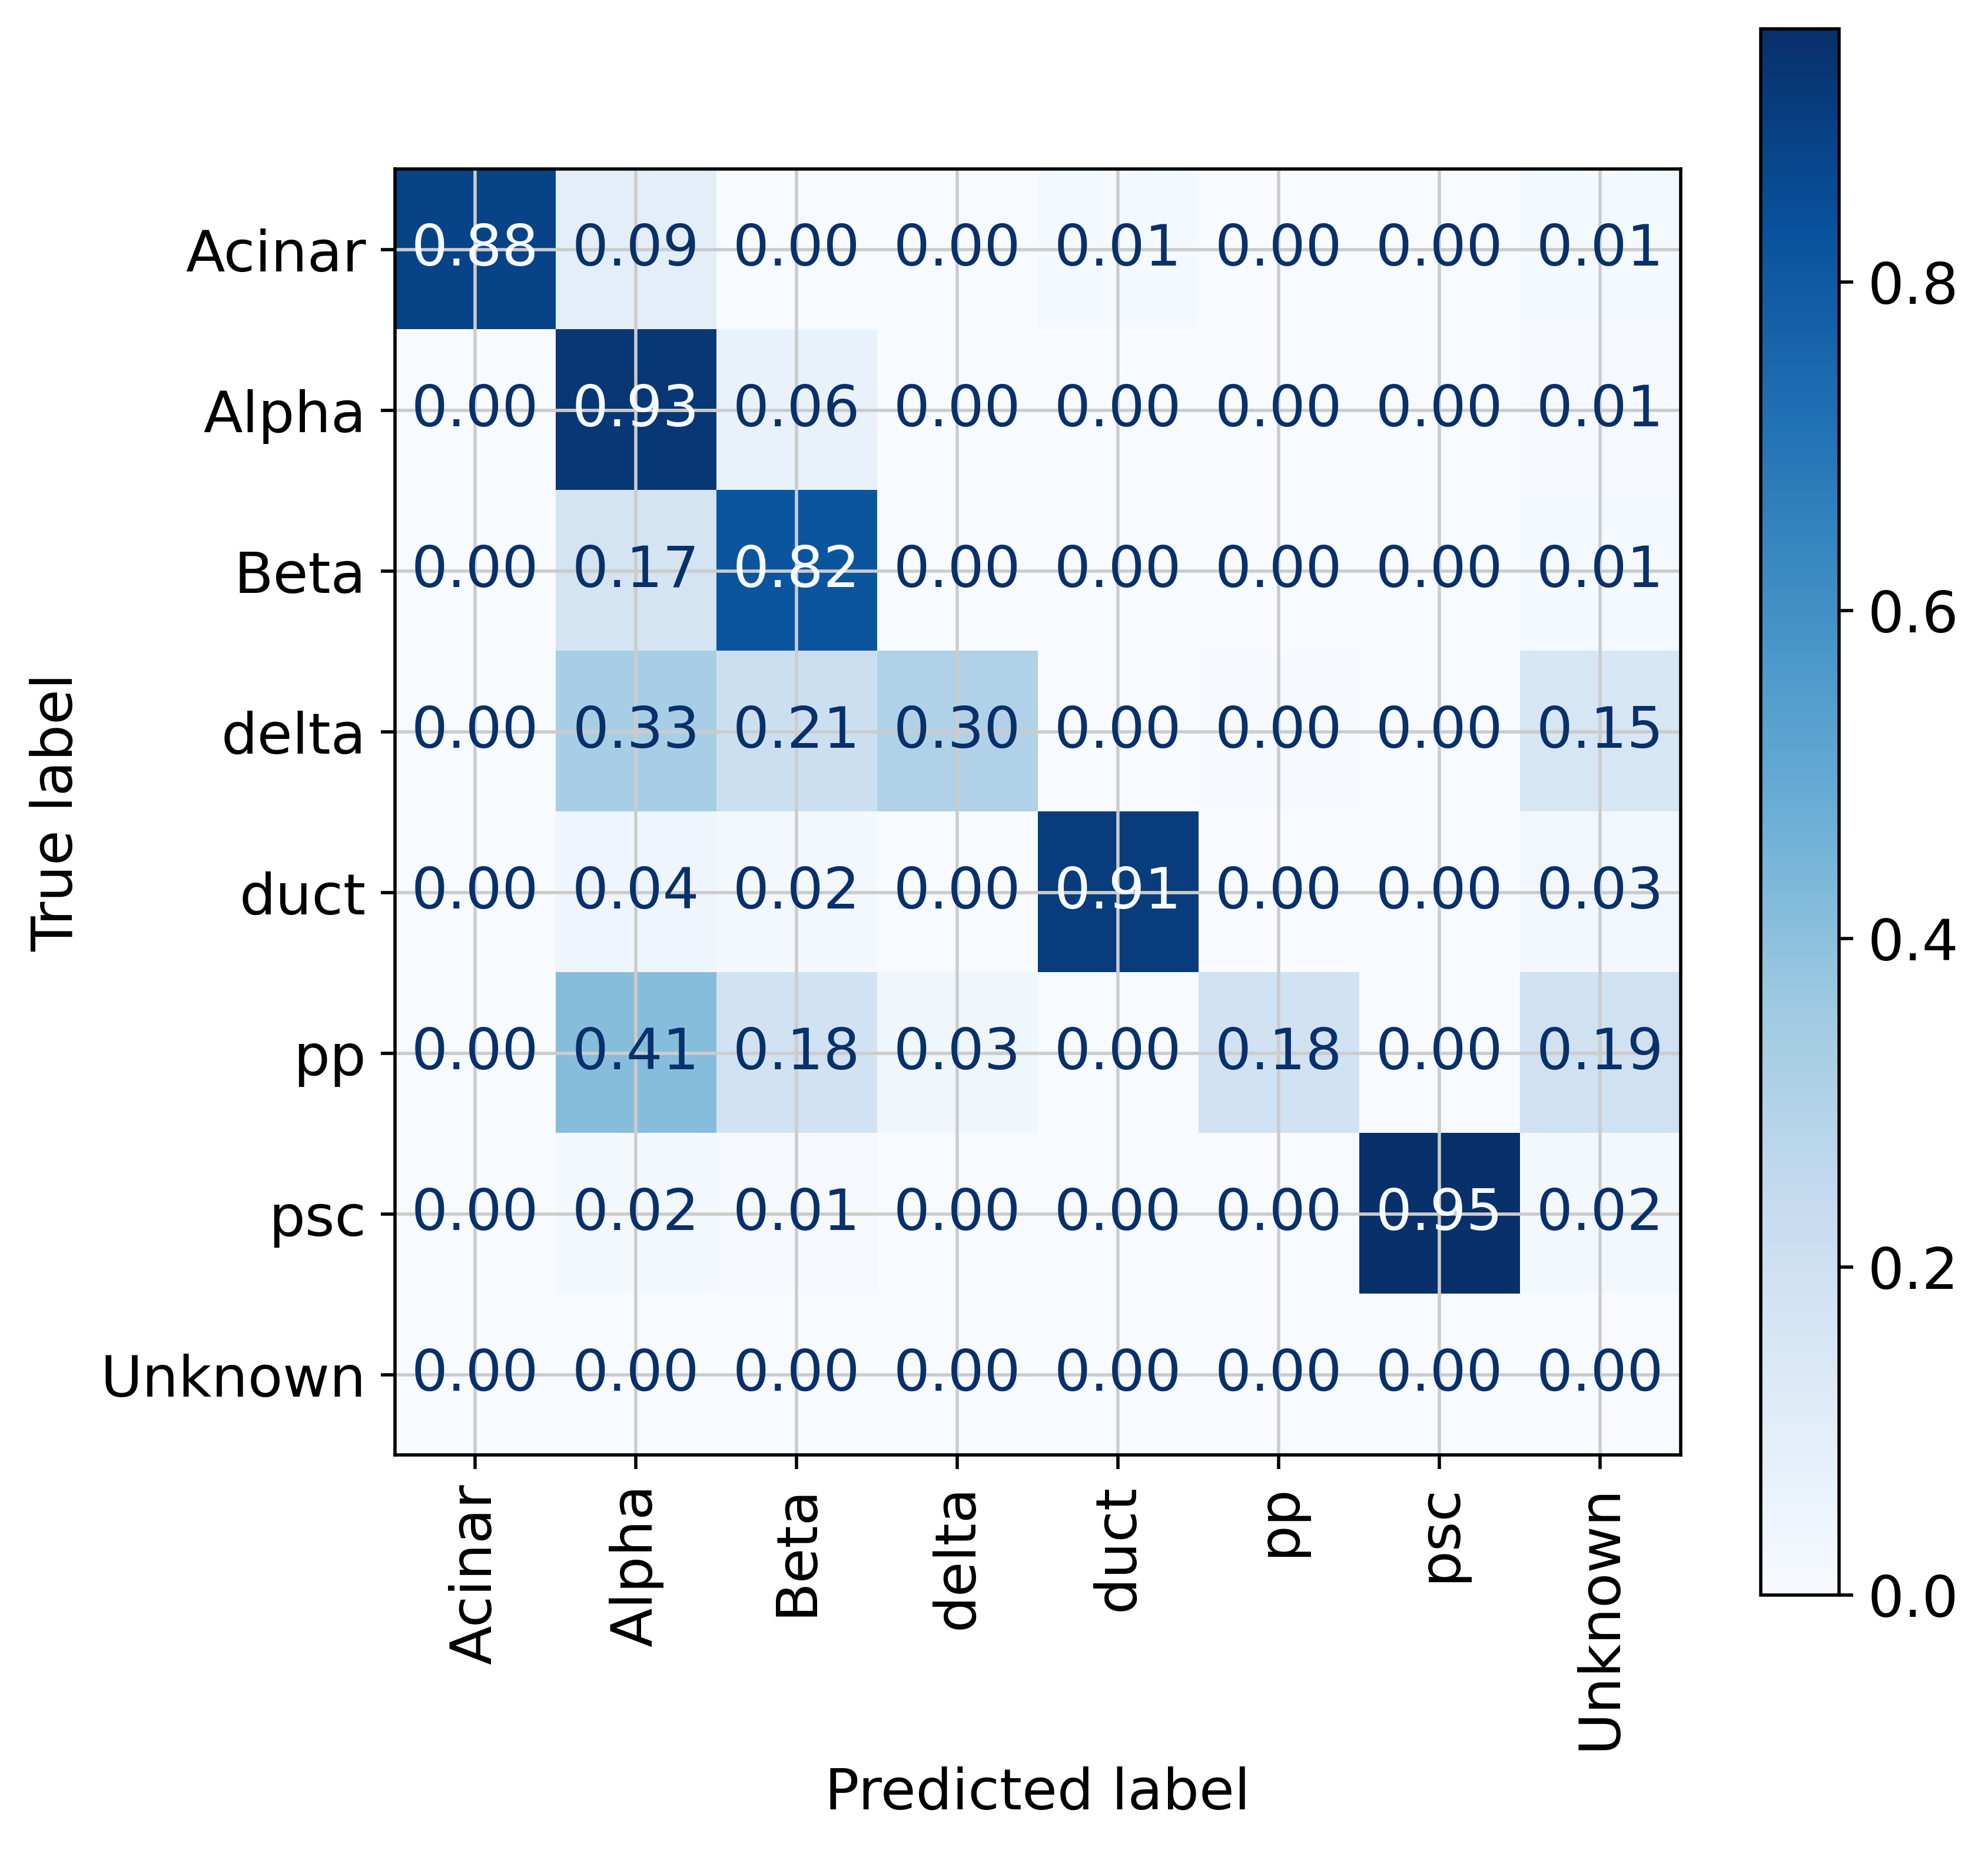

In [31]:
fig, ax = plt.subplots(figsize=(7,7))
disp = metrics.ConfusionMatrixDisplay.from_predictions(
    y_true=all_true3,
    y_pred=all_pred3,
    labels=classes + ["Unknown"],
    cmap=plt.cm.Blues,
    normalize="true",
    values_format='.2f',
    xticks_rotation="vertical",
    ax=ax
)


## Salvar os resultados

In [45]:
results1.to_csv("./SVMrej_metricas1.csv")
results2.to_csv("./SVMrej_metricas2.csv")
results3.to_csv("./SVMrej_metricas3.csv")